# Introduction into dataset

In the project I'll be working with a dataset that contains various technical information on cars, including: the motor's displacement, the weight of the car, the miles per gallon, how fast the car accelerates, and more.

I will be using this data to predict the cars market value based on some key attributes.

In [1]:
import pandas as pd
import numpy as np

pd.options.display.max_columns = 99

cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
cars = pd.read_csv('imports-85.data', names=cols)
print(cars.head())

   symboling normalized-losses         make fuel-type aspiration num-of-doors  \
0          3                 ?  alfa-romero       gas        std          two   
1          3                 ?  alfa-romero       gas        std          two   
2          1                 ?  alfa-romero       gas        std          two   
3          2               164         audi       gas        std         four   
4          2               164         audi       gas        std         four   

    body-style drive-wheels engine-location  wheel-base  length  width  \
0  convertible          rwd           front        88.6   168.8   64.1   
1  convertible          rwd           front        88.6   168.8   64.1   
2    hatchback          rwd           front        94.5   171.2   65.5   
3        sedan          fwd           front        99.8   176.6   66.2   
4        sedan          4wd           front        99.4   176.6   66.4   

   height  curb-weight engine-type num-of-cylinders  engine-size fue

In [2]:
# Select only the columns with continuous values from - https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.names
continuous_values_cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
numeric_cars = cars[continuous_values_cols]

In [3]:
numeric_cars.head(5)

,normalized-losses,wheel-base,length,width,height,curb-weight,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,?,88.6,168.8,64.1,48.8,2548,3.47,2.68,9.0,111,5000,21,27,13495
1,?,88.6,168.8,64.1,48.8,2548,3.47,2.68,9.0,111,5000,21,27,16500
2,?,94.5,171.2,65.5,52.4,2823,2.68,3.47,9.0,154,5000,19,26,16500
3,164,99.8,176.6,66.2,54.3,2337,3.19,3.40,10.0,102,5500,24,30,13950
4,164,99.4,176.6,66.4,54.3,2824,3.19,3.40,8.0,115,5500,18,22,17450


# Data Cleaning

In [4]:
numeric_cars = numeric_cars.replace('?', np.nan)

In [5]:
numeric_cars = numeric_cars.astype('float')
numeric_cars.isnull().sum()

normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

In [6]:
# Because `price` is the column we want to predict, let's remove any rows with missing `price` values.
numeric_cars = numeric_cars.dropna(subset=['price'])
numeric_cars.isnull().sum()

normalized-losses    37
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 0
dtype: int64

In [7]:
# Replace missing values in other columns using column means.
numeric_cars = numeric_cars.fillna(numeric_cars.mean())

In [8]:
# Confirm that there's no more missing values.
numeric_cars.isnull().sum()

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
bore                 0
stroke               0
compression-rate     0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

In [9]:
# Normalize all columnns to range from 0 to 1 except the target column.
price_col = numeric_cars['price']
numeric_cars = (numeric_cars - numeric_cars.min())/(numeric_cars.max() - numeric_cars.min())
numeric_cars['price'] = price_col

# Univariate model

To start with im going to perform analysis using a simple univariate model to help understand the features of the dataset better before moving on to more complex models.

In [10]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

def knn_train_test(train_col, target_col, df):
    knn = KNeighborsRegressor()
    np.random.seed(1)
        
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    # Fit a KNN model using default k value.
    knn.fit(train_df[[train_col]], train_df[target_col])
    
    # Make predictions using model.
    predicted_labels = knn.predict(test_df[[train_col]])

    # Calculate and return RMSE.
    mse = mean_squared_error(test_df[target_col], predicted_labels)
    rmse = np.sqrt(mse)
    return rmse

rmse_results = {}
train_cols = numeric_cars.columns.drop('price')

# For each column (minus `price`), train a model, return RMSE value
# and add to the dictionary `rmse_results`.
for col in train_cols:
    rmse_val = knn_train_test(col, 'price', numeric_cars)
    rmse_results[col] = rmse_val

# Create a Series object from the dictionary so 
# we can easily view the results, sort, etc
rmse_results_series = pd.Series(rmse_results)
rmse_results_series.sort_values()

horsepower           4037.037713
curb-weight          4401.118255
highway-mpg          4630.026799
width                4704.482590
city-mpg             4766.422505
length               5427.200961
wheel-base           5461.553998
compression-rate     6610.812153
bore                 6780.627785
normalized-losses    7330.197653
peak-rpm             7697.459696
stroke               8006.529545
height               8144.441043
dtype: float64

In [20]:
def knn_train_test(train_col, target_col, df):
    np.random.seed(1)
        
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [1,3,5,7,9]
    k_rmses = {}
    
    for k in k_values:
        # Fit model using k nearest neighbors.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[[train_col]], train_df[target_col])

        # Make predictions using model.
        predicted_labels = knn.predict(test_df[[train_col]])

        # Calculate and return RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}

# For each column (minus `price`), train a model, return RMSE value
# and add to the dictionary `rmse_results`.
train_cols = numeric_cars.columns.drop('price')
for col in train_cols:
    rmse_val = knn_train_test(col, 'price', numeric_cars)
    k_rmse_results[col] = rmse_val

k_rmse_results

{'bore': {1: 8602.58848450066,
  3: 6984.239489480916,
  5: 6780.627784685976,
  7: 6878.097965921532,
  9: 6866.808502038413},
 'city-mpg': {1: 5901.143574354764,
  3: 4646.746408727155,
  5: 4766.422505090134,
  7: 5232.523034167316,
  9: 5465.209492527533},
 'compression-rate': {1: 8087.205346523092,
  3: 7375.063685578359,
  5: 6610.812153159129,
  7: 6732.801282941515,
  9: 7024.485525463435},
 'curb-weight': {1: 5264.290230758878,
  3: 5022.318011757233,
  5: 4401.118254793124,
  7: 4330.608104418053,
  9: 4632.044474454401},
 'height': {1: 8904.04645636071,
  3: 8277.609643045525,
  5: 8144.441042663747,
  7: 7679.598124393773,
  9: 7811.03606291223},
 'highway-mpg': {1: 6025.594966720739,
  3: 4617.305019788554,
  5: 4630.026798588056,
  7: 4796.061440186946,
  9: 5278.358056953987},
 'horsepower': {1: 4170.054848037801,
  3: 4020.8492630885394,
  5: 4037.0377131537603,
  7: 4353.811860277134,
  9: 4515.135617419103},
 'length': {1: 4628.45550121557,
  3: 5129.8358210721635,
  

# Mulitvariate Model

In [23]:
# First I want to find the best feature from the last step by 
# Compute average RMSE across different`k` values for each feature.
feature_avg_rmse = {}
for k,v in k_rmse_results.items():
    avg_rmse = np.mean(list(v.values())) # .values is needed as values are within 2nd dict
    feature_avg_rmse[k] = avg_rmse
series_avg_rmse = pd.Series(feature_avg_rmse)
series_avg_rmse.sort_values()

horsepower           4219.377860
width                4618.910560
curb-weight          4730.075815
highway-mpg          5069.469256
length               5176.394904
city-mpg             5202.409003
wheel-base           5252.392462
compression-rate     7166.073599
bore                 7222.472445
normalized-losses    7624.407151
stroke               8000.240467
peak-rpm             8119.365233
height               8163.346266
dtype: float64

In [24]:
def knn_train_test(train_cols, target_col, df):
    np.random.seed(1)
    
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [5]
    k_rmses = {}
    
    for k in k_values:
        # Fit model using k nearest neighbors.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[train_cols], train_df[target_col])

        # Make predictions using model.
        predicted_labels = knn.predict(test_df[train_cols])

        # Calculate and return RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}

In [25]:
two_best_features = ['horsepower', 'width']
rmse_val = knn_train_test(two_best_features, 'price', numeric_cars)
k_rmse_results["two best features"] = rmse_val

three_best_features = ['horsepower', 'width', 'curb-weight']
rmse_val = knn_train_test(three_best_features, 'price', numeric_cars)
k_rmse_results["three best features"] = rmse_val

four_best_features = ['horsepower', 'width', 'curb-weight', 'city-mpg']
rmse_val = knn_train_test(four_best_features, 'price', numeric_cars)
k_rmse_results["four best features"] = rmse_val

five_best_features = ['horsepower', 'width', 'curb-weight' , 'city-mpg' , 'highway-mpg']
rmse_val = knn_train_test(five_best_features, 'price', numeric_cars)
k_rmse_results["five best features"] = rmse_val

six_best_features = ['horsepower', 'width', 'curb-weight' , 'city-mpg' , 'highway-mpg', 'length']
rmse_val = knn_train_test(six_best_features, 'price', numeric_cars)
k_rmse_results["six best features"] = rmse_val

k_rmse_results

{'five best features': {5: 3341.6024539726504},
 'four best features': {5: 3280.3807311630976},
 'six best features': {5: 3628.261188214127},
 'three best features': {5: 3305.9401397969677},
 'two best features': {5: 3589.3132622073304}}

In [26]:
# Now let's optimize the model that performed the best in the last step.
# By varying the hyperparameter k
def knn_train_test(train_cols, target_col, df):
    np.random.seed(1)
    
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = range(1,25)
    k_rmses = {}
    
    for k in k_values:
        # Fit model using k nearest neighbors.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[train_cols], train_df[target_col])

        # Make predictions using model.
        predicted_labels = knn.predict(test_df[train_cols])

        # Calculate and return RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}

In [28]:
three_best_features = ['horsepower', 'width', 'curb-weight']
rmse_val = knn_train_test(three_best_features, 'price', numeric_cars)
k_rmse_results["three best features"] = rmse_val

four_best_features = ['horsepower', 'width', 'curb-weight', 'city-mpg']
rmse_val = knn_train_test(four_best_features, 'price', numeric_cars)
k_rmse_results["four best features"] = rmse_val

five_best_features = ['horsepower', 'width', 'curb-weight' , 'city-mpg' , 'highway-mpg']
rmse_val = knn_train_test(five_best_features, 'price', numeric_cars)
k_rmse_results["five best features"] = rmse_val

k_rmse_results

{'five best features': {1: 2530.0554077602005,
  2: 2897.1757974767684,
  3: 3183.4597426217424,
  4: 3168.0230415758415,
  5: 3341.6024539726504,
  6: 3537.520542998191,
  7: 3817.290452118825,
  8: 4004.414529685573,
  9: 3992.3186041830318,
  10: 4138.728787853335,
  11: 4342.052852829098,
  12: 4416.145381031136,
  13: 4493.8798141857205,
  14: 4463.501601554571,
  15: 4474.480783207805,
  16: 4553.5595362768345,
  17: 4597.001081375769,
  18: 4655.283442648355,
  19: 4687.900893982822,
  20: 4712.022985543165,
  21: 4755.856625823773,
  22: 4788.162720030673,
  23: 4806.923381965054,
  24: 4879.983352195467},
 'four best features': {1: 2516.589279950226,
  2: 2811.1727257604443,
  3: 3013.3615157930335,
  4: 3126.269482641261,
  5: 3280.3807311630976,
  6: 3479.5099401018138,
  7: 3781.5612742414464,
  8: 3988.8669577450623,
  9: 4024.998621362245,
  10: 4042.247226187899,
  11: 4230.335248684068,
  12: 4354.008675154061,
  13: 4461.626664877788,
  14: 4468.029845088927,
  15: 444

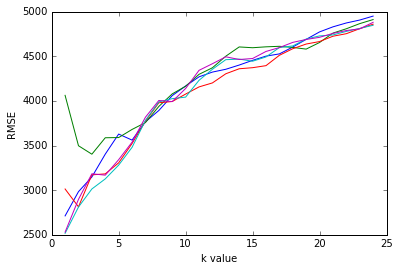

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

for k,v in k_rmse_results.items():
    x = list(v.keys())
    y = list(v.values())
    
    plt.plot(x,y)
    plt.xlabel('k value')
    plt.ylabel('RMSE')

It seems that all models have an optimal k-value somewhere below 5, this could be because the classes are so close that any large enough k number begins to include values from other classes.

SyntaxError: unexpected EOF while parsing (<ipython-input-59-821ee834832b>, line 1)